In [2]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the data
df = pd.read_pickle("../data/survey.pkl")

# Drop unnecessary columns
df.drop(columns=["duration", "prediction_num", "prediction", "weighted_prediction", "weighted_prediction_num", "user_id"], inplace=True)

In [5]:
# Try to find Pair Ids where Human Certainty is above Machine Certainty and prediction is correct, but for machine is not correct
filter1 = (df.model == "Human") & (df.correct) & (df.certainty > 0.90)
filter2 = (df.model == "FaceTrans*") & (~df.correct)
merged_df = pd.merge(df[filter1], df[filter2], on=["pair_id", "dataset", "label"], suffixes=("_Human", "_AI"))
filtered_df = merged_df[merged_df["certainty_Human"] > merged_df["certainty_AI"]]
filtered_df["certainty_diff"] = filtered_df.certainty_Human - filtered_df.certainty_AI

# print the sorted dataframe
filtered_df.sort_values(by=["certainty_Human"], ascending=False, inplace=True)
filtered_df.reset_index(inplace=True)
print(filtered_df.groupby(["dataset", "pair_id"]).head().to_markdown(floatfmt=".2%"))

|     |   index |   certainty_Human | dataset   |   pair_id | model_Human   | label   | correct_Human   |   certainty_AI | model_AI   | correct_AI   |   certainty_diff |
|----:|--------:|------------------:|:----------|----------:|:--------------|:--------|:----------------|---------------:|:-----------|:-------------|-----------------:|
|   0 |     138 |           100.00% | cplfw     |      4136 | Human         | False   | True            |         46.93% | FaceTrans* | False        |           53.07% |
|   1 |      83 |           100.00% | cplfw     |      3645 | Human         | True    | True            |         50.30% | FaceTrans* | False        |           49.70% |
|   2 |      81 |           100.00% | calfw     |      5410 | Human         | True    | True            |         71.81% | FaceTrans* | False        |           28.19% |
|   3 |      80 |           100.00% | base      |      5543 | Human         | True    | True            |         22.42% | FaceTrans* | False        |

In [6]:
# See how many pairs in each dataset have this property divided by total amount of pairs per dataset
print("Pairs with Human Certainty > AI Certainty and Human Prediction is correct but AI is not:")
print(filtered_df.groupby(["dataset"]).size().rename("counts").to_markdown())

Pairs with Human Certainty > AI Certainty and Human Prediction is correct but AI is not:
| dataset   |   counts |
|:----------|---------:|
| base      |       23 |
| calfw     |       20 |
| cplfw     |       35 |
| mlfw      |       50 |
| xqlfw     |       10 |


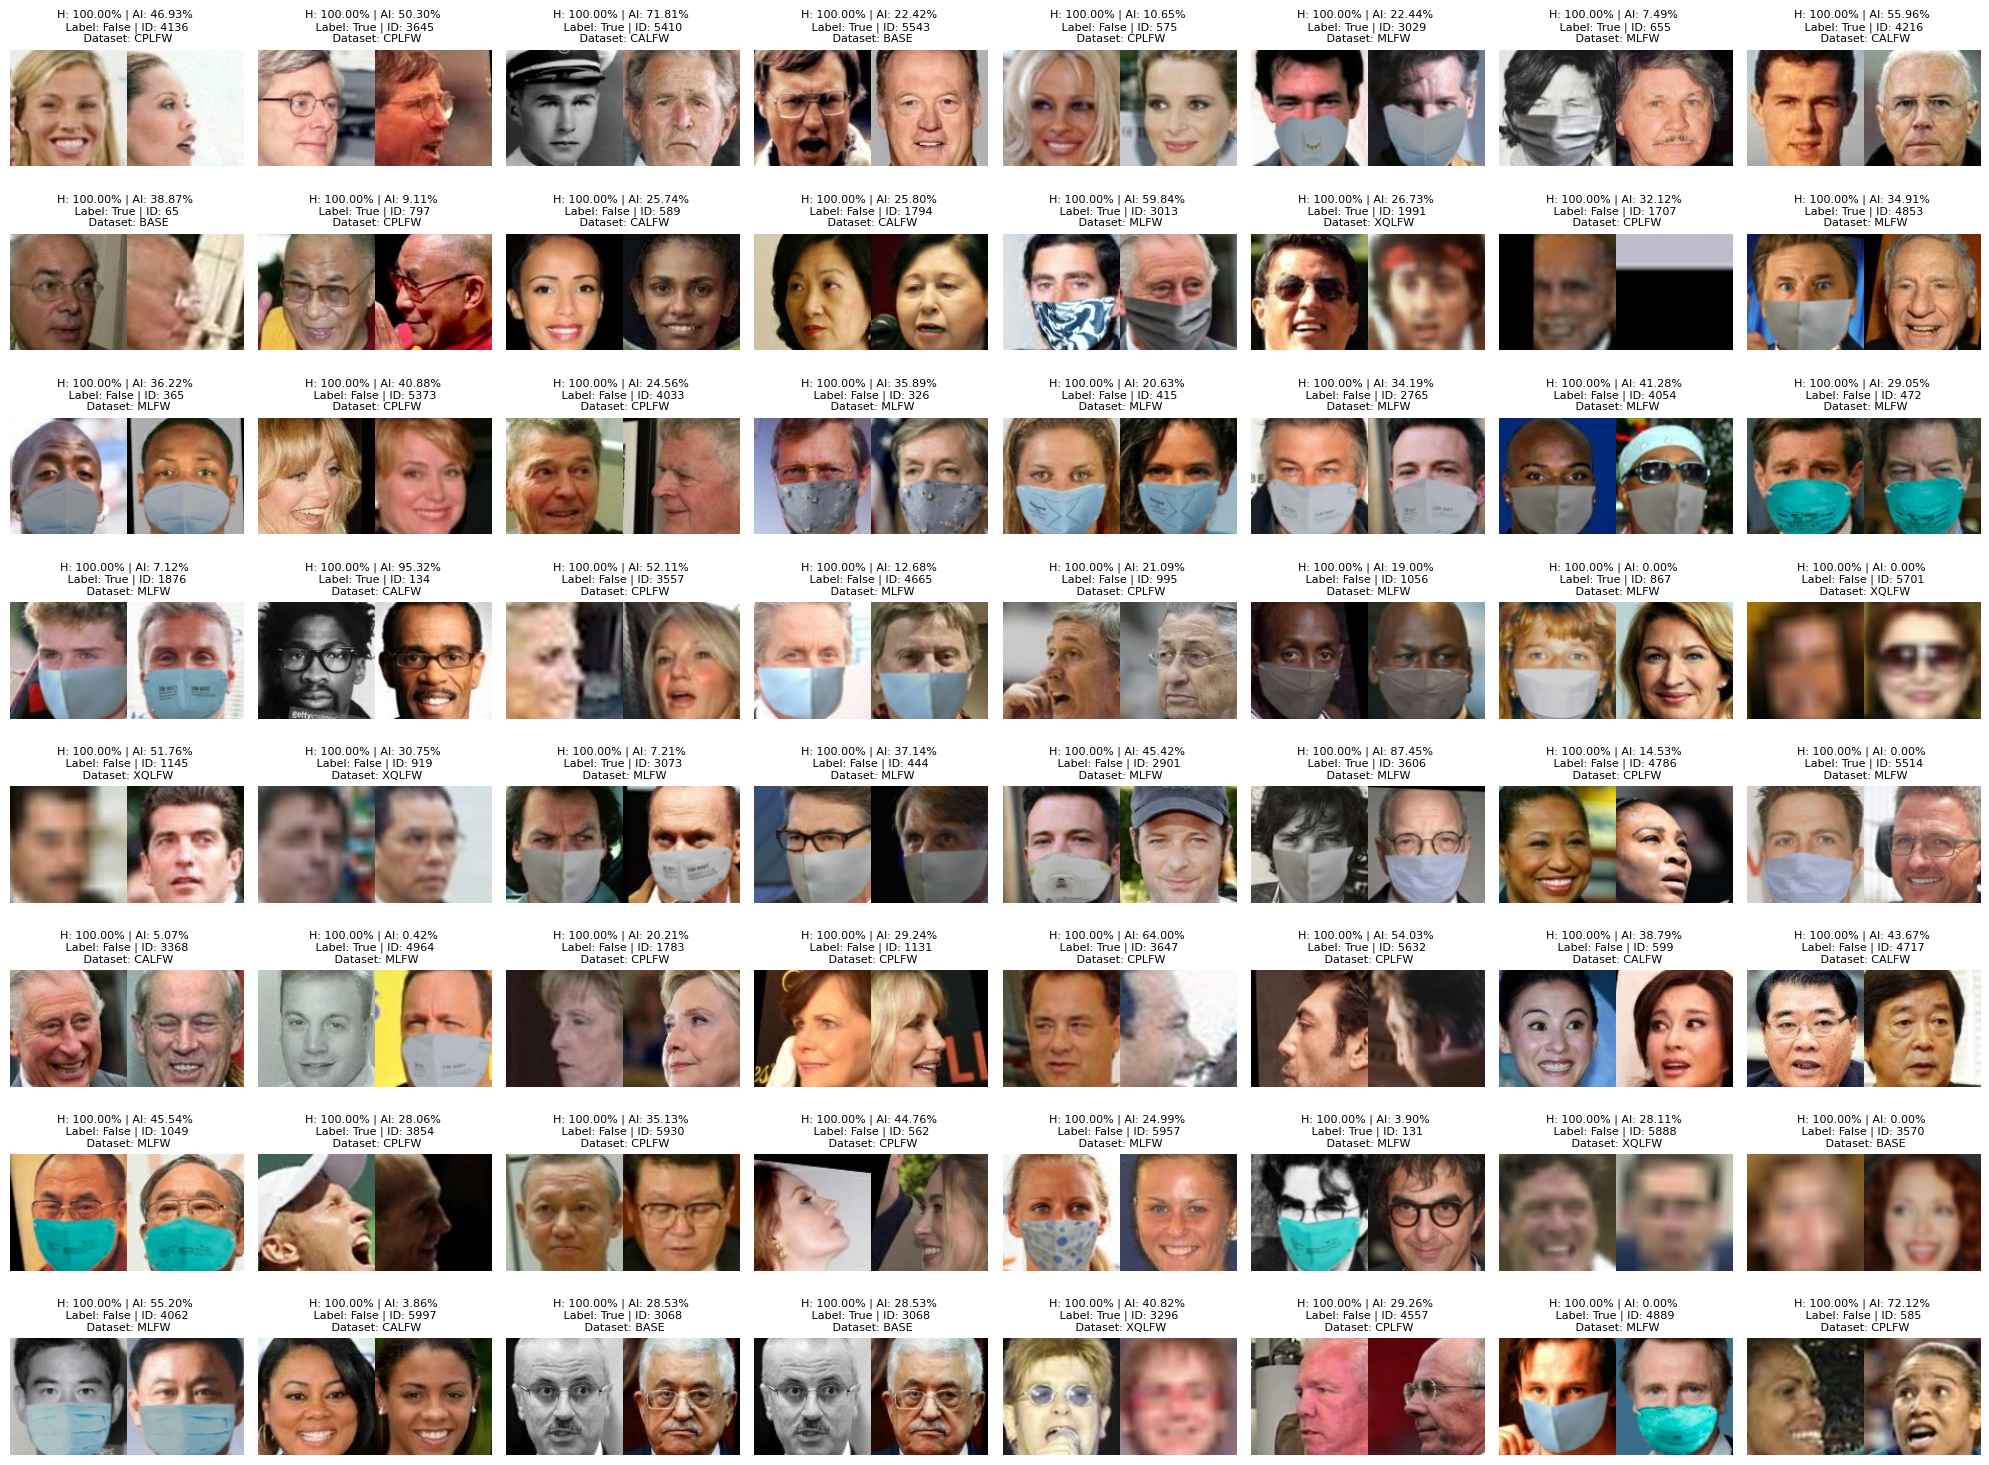

In [8]:
# Make a image composition of the first 64 images in an 8x8 grid with information as title

n = 8  # number of images per row and column
fig, axs = plt.subplots(n, n, figsize=(20, 20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i, row in filtered_df.head(n * n).iterrows():
    img1 = plt.imread(f"../datasets/{row['dataset']}/{row['pair_id']:04d}_0.png")
    img2 = plt.imread(f"../datasets/{row['dataset']}/{row['pair_id']:04d}_1.png")
    img = np.concatenate((img1, img2), axis=1)
    axs[i // n, i % n].imshow(img)
    axs[i // n, i % n].set_title(
        f"H: {row['certainty_Human']:.2%} | AI: {row['certainty_AI']:.2%} \n Label: {row['label']} | ID: {row['pair_id']} \n Dataset: {row['dataset'].upper()}",
        fontsize=8,
    )
    axs[i // n, i % n].axis("off")
plt.tight_layout()

plt.savefig("../figures/sup_all_pairs.png")  # save the figure

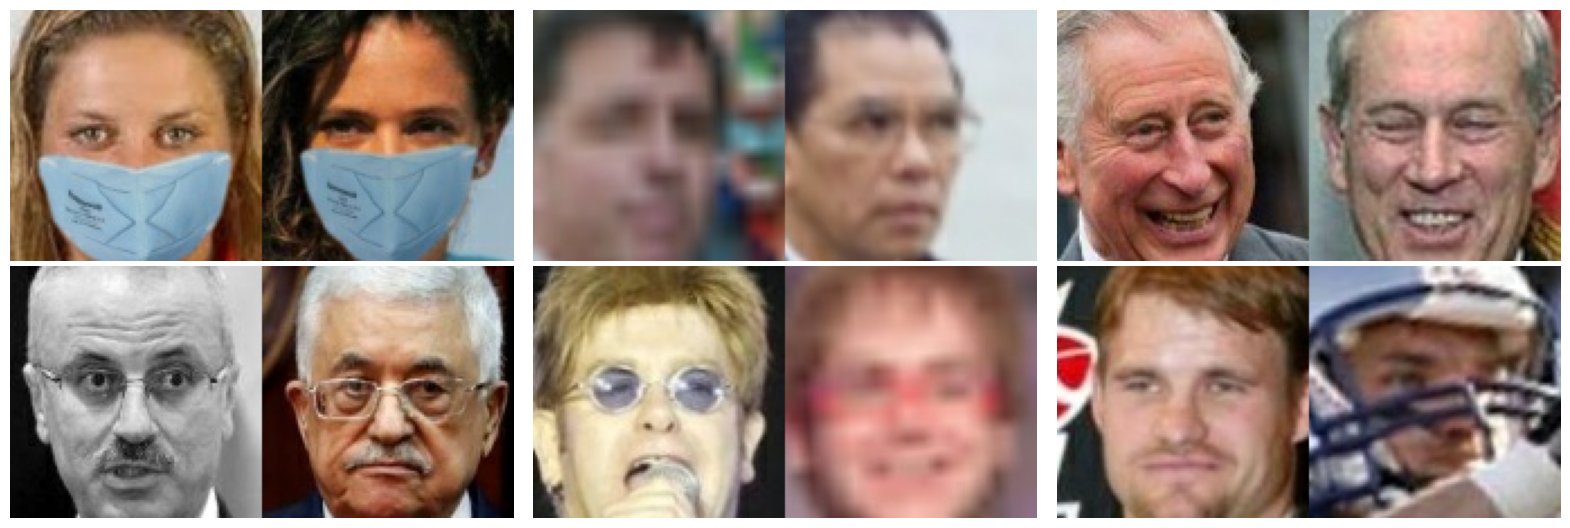

In [9]:
# By Visual inspection we select a few pairs that are interesting to look at
interesting = [("mlfw", 415), ("base", 3068), ("cplfw", 3239), ("xqlfw", 3296), ("calfw", 3368), ("xqlfw", 919)]

interesting_df = (
    filtered_df[filtered_df[["dataset", "pair_id"]].apply(tuple, axis=1).isin(interesting)]
    .drop_duplicates(subset=["dataset", "pair_id"])
    .reset_index()
)

# Plot the interesting pairs in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.04, hspace=-0.8)
for i, row in interesting_df.head(n * n).iterrows():
    img1 = plt.imread(f"../datasets/{row['dataset']}/{row['pair_id']:04d}_0.png")
    img2 = plt.imread(f"../datasets/{row['dataset']}/{row['pair_id']:04d}_1.png")
    img = np.concatenate((img1, img2), axis=1)
    axs[i // 3, i % 3].imshow(img)
    # axs[i // 3, i % 3].set_title(f"H: {row['certainty_Human']:.2%} | AI: {row['certainty_AI']:.2%} \n Label: {row['label']} | ID: {row['pair_id']} \n Dataset: {row['dataset'].upper()}", fontsize=18)
    axs[i // 3, i % 3].axis("off")

fig.savefig("../figures/findpairs.pdf", bbox_inches="tight")  # save the figure